## **Introduction to Artificial Intelligence - Computer Assignment 1-Genetic Algorithms**

## *Amin Aghakasiri*
## *Student ID : 810101381*

### *Summary and Purpose of the project*
In this project, we are supposed to find a solution for knapsack problem with some additional constraints with the help of genetic algorithm. 
The problem that we should solve is the knapsack problem but with 4 constraints:
* The sum of the values of the items must be bigger than an input value.
* The sum of the weights of the items must be smaller than an input weight.
* The number of items that we pick must be between an input range.
* Each item that we pick shouldn't exceed it's weight.

So there are some important factors for solving this problem using genetic algorithm. Here is an overview of steps for solving the problem:
* Define reasonable genes for making chromosomes that nicely satisfy the needs of the problem.
* Define crossover and mutation with suitable probabilities that make the generations better.
* Define a good fitness function that is mostly ascending.
* Evalute the best approach for the problem by changing the hyper-parameters and making the three previous steps better in order to reach a more optimal answer.

In [7]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

### *Hyper-parameters*
Hyper-parameters are very important in the problems that we want to solve with genetic algorithms becuase mostly we don't know the optimal solution in these problems (because of the various data that we have in these problems). So it is very important to change the these parameters in order to find the better solution. Here are my parameters for this problem:
* `NUM_OF_FOODS` : Number of foods which comes in the input.
* `MAX_WEIGHT` : Maximum sum of weights of items which comes in the input.
* `MIN_VALUE` : Minimum sum of values of items which comes in the input.
* `MIN_SNACKS_NUM` : Minimum number of items that we can pick which comes in the input.
* `MAX_SNACKS_NUM` : Maximum number of items that we can pick which comes in the input.
* `POPULATION_SIZE` : The number of chromosomes in each generation.
* `NUM_OF_ITERS` : Number of generations that we produce in order to find a good solution.
* `MUTATION_PROB` : The probability of changing each bit in the mutation process.
* `CROSSOVER_RATE` : The rate of performing a crossover for each pair of chromosomes.
* `CROSSOVER_PROB` : The probability of swaping each pair of bits in the process of uniform crossover in order to make new childs.
* `NORMALIZER` : A normalizer in my fitness function.

In [8]:
NUM_OF_FOODS = 19
MAX_WEIGHT = 10
MIN_VALUE = 12
MIN_SNACKS_NUM = 2
MAX_SNACKS_NUM = 4
POPULATION_SIZE = 200
NUM_OF_ITERS = 1000
MUTATION_PROB = 0.01
CROSSOVER_RATE = 0.9
CROSSOVER_PROB = 0.8
NORMALIZER = 10

### *Classes and Functions*

#### 1. Snack
This class is for maintaining the name, weight and value of each food that comes in the input. Also, I have loaded the data from the csv file and made an instantiate of Stack class for it and stored it's each food weight,name and value in it and appended it in the foods list.

In [9]:
class Snack:
    def __init__(self, food, weight, value) -> None:
        self.food = food
        self.weight = weight
        self.value = value
    def get_name(self):
        return self.food
    def get_weight(self):
        return self.weight
    def get_value(self):
        return self.value
foods = []
df = pd.read_csv("snacks.csv")
for i in df.index:
    foods.append(Snack(df["Snack"][i], df["Available Weight"][i], df["Value"][i]))

#### 2. Chromosome
This class is for maintaining each chromosome that has a list of genes in itself.
* `uniform_crossover` : This function takes another chromosome as input and perform a uniform crossover with given probability and returns 2 childs.
* `mutate` : This function perform the mutation process on the chromosome.

Each gene that I have defined for this problem represents the amount of weight for the item between zero and the maximum weight of that item. So each chromosome contains all foods which is given in the input and each index (gene) represents the weight of that food in the chromosome (which is a solution itself).

In [10]:
class Chromosome:
    def __init__(self, genes) -> None:
        self.genes = genes
    def uniform_crossover(self, crossover_prob, parent):
        first_child = []
        second_child = []
        temp = parent.get_genes()
        for i in range(len(self.genes)):
            if random.random() < crossover_prob:
                first_child.append(self.genes[i])
                second_child.append(temp[i])
            else:
                second_child.append(self.genes[i])
                first_child.append(temp[i])
        child1, child2 = Chromosome(first_child), Chromosome(second_child)
        return child1, child2
    def mutate(self, mutate_prob):
        for i in range(len(self.genes)):
            if random.random() < mutate_prob:
                if self.genes[i] == 0:
                    continue
                self.genes[i] = random.uniform(0, foods[i].get_weight())
    def get_genes(self):
        return self.genes

#### 3. Knapsack
The Knapsack class is the top level class. The main processes for solving this problems are handled in this class. I will explain the important methods of this class.

`first_generate()` : This function generates the first generation with random number of genes (should be in the legal range) and random weight for each selected gene.

`calc_fitness()` : This function calculates the fitness function and the purpose of it is to maximize the final value of items which is the purpose of the knapsack problem. For calculating the fitness function, I have used three coefficients called W_weight (for weight), W_value (for value) and W_items (for items). Then I have calculate a division that the numerator is the total value and the denominator is the total weight of items with 3 coefficients. The reason of the power of 2 for the weight coefficient is that the maximum weight constraint was a bigger problem for my algorithm and thus, it was more important than the other two. The logic behind this fitness is obvious because in the knapsack problem, we want to maximize the total value (for that, it is in the nomerator) with restricted weight and some constraints (for that, they are in the denominator). The process of calculating these three coefficients is implemented in the code. At last, the final fitness value is caculated from below equation:

$$fitness = \frac{total_{value}}{\left| total_{weight}* w_{items} * w_{value} * w_{weight}^2 \right|} * NORMALIZER$$


I have tried lots of different fitness functions but most of them weren't good enough, mostly because of not correctly considering the coefficient of different factors and at last, I reached this one that was better than the others. I have commented 2 other fitness functions that I have wrote before in the `calc_fitness()` method.

`calc_rank()` : This function calculates the fitness values for each chromosome and then sort them in ascending order based on their fitnesses. After that, I have normalized the probability for each chromosome with below formula (i is the index of the chomosome in the list):
$$rank_{i} = \frac{i+1}{\sum_{k=0}^{n}k}$$

This is done because of the increasement of the probability of chromosomes that have very low fitness.

`calc_average_fitness()` : This function is used for calculating the average fitness of a population that is used for the final plot that shows the process of growth of the average fitnesses of generations.

`select()` : This function is used for the process of making the mating pool. First, it will choose number of foods that it should be in the new population based on the probabilities of rank-based popuation generated in `calc_rank()` function which is the roulette wheel technique. At the end, I have shuffled the new population list so that some chromosomes with high probabilty don't come consecutive (and vice versa for low probabilities).

`find_solution()` : In this function, I have used the previous methods to produce new populations to the desired iterations' number determined in the `NUM_OF_ITERS` parameter. In each iteration, it makes a new population with the below procedure:

* Rank calculation
* Selection
* Perform crossover with desired rate and probability
* Perform mutation
* Make new population 


In [11]:
class Knapsack:
    def __init__(self, population_size, crossover_prob, mutate_prob, crossover_rate, num_of_foods, max_snacks_num, min_snacks_num, num_of_iterations, max_weight, min_value) -> None:
        self.population = []
        self.population_size = population_size
        self.crossover_prob = crossover_prob
        self.mutate_prob = mutate_prob
        self.num_of_foods = num_of_foods
        self.max_snacks_num = max_snacks_num
        self.min_snacks_num = min_snacks_num
        self.num_of_iterations = num_of_iterations
        self.crossover_rate = crossover_rate
        self.max_weight = max_weight
        self.min_value = min_value
        self.min_snacks_num = min_snacks_num
        self.max_snacks_num = max_snacks_num
        # Number of times that we have generated generations until now
        self.num_of_generations = 0
    def first_generate(self):
        # I've generated maximum number of foods that given in the input for the populations of the first generation
        for _ in range(self.population_size):
            num_of_genes = random.randint(self.min_snacks_num, self.max_snacks_num)
            # genes = [0.0] * self.num_of_foods
            genes = np.zeros(self.num_of_foods,dtype=float)
            # random maximum number of ligal indexes for placing first generations
            random_idxs = []
            for _ in range(num_of_genes):
                random_idxs.append(random.randint(0,self.num_of_foods - 1))
            for i in range(len(random_idxs)):
                genes[random_idxs[i]] = random.uniform(0, foods[random_idxs[i]].get_weight())
            new = Chromosome(genes)
            self.population.append(new)
        self.num_of_generations += 1
    def calc_fitness(self, chromosome):
        W_value, W_weight, W_items = 0, 0, 0
        total_value, total_weight, total_items = 0, 0, 0
        genes = chromosome.get_genes()
        for i in range(len(genes)):
            if genes[i] != 0:
                total_items += 1
            total_weight += genes[i]
            total_value += (genes[i] / foods[i].get_weight()) * foods[i].get_value()
        # Determining the three coefficients:
        # (+1) is for normalizing the denominator and do not permit it to be 0!
        # the conditions that results to 1 is for the states that doesn't violate that constraint!
        if total_weight >= self.max_weight:
            W_weight = 2
        else:
            W_weight = self.max_weight - total_weight + 1
        

        if total_value < self.min_value:
            W_value = self.min_value - total_value + 1
        else:
            W_value = 1


        if total_items > self.max_snacks_num:
            W_items = total_items - self.max_snacks_num + 1
        elif total_items < self.min_snacks_num:
            W_items = self.min_snacks_num - total_items + 1
        else:
            W_items = 1
        # Find a better fitness value after trynig many of them! (1 in the denominator is for preventing the denominator to become 0)
        fitness = (total_value / ((abs(total_weight) * (W_items * (W_value) * (W_weight**2)) + 1))) * NORMALIZER
        return fitness
    
        # One of my previous fitnesses:
        # fitness = ((W_weight * W_value * W_items) * total_value) / ((total_weight + NORMALIZER))
    

        # My first fitness function(doesn't correctly apply the effect of weight!)
        # penalty = 0
        # if total_weight > MAX_WEIGHT:
        #     penalty = total_weight - 100 * MAX_WEIGHT
        #     total_value -= penalty
        # if total_value < MIN_VALUE:
        #     penalty = MIN_VALUE - total_value
        #     total_value -= penalty
        # if total_items < MIN_SNACKS_NUM or total_items > MAX_SNACKS_NUM:
        #     penalty = abs(total_items - (MIN_SNACKS_NUM + MAX_SNACKS_NUM)/2)
        #     total_value -= penalty
        # return total_value / total_weight


    def calc_rank(self):
        rank = []
        for x in self.population:
            rank.append((x, self.calc_fitness(x)))
        rank = sorted(rank, key=lambda x : x[1])
        t = len(rank)
        temp_sum = (t*(t+1)) / 2
        for i in range(t):
            # rank: (index + 1) / sum(index)
            rank[i] = tuple([rank[i][0], (i+1) / temp_sum])
        return rank
    
    def calc_average_fitness(self):
        temp = 0
        for x in self.population:
            temp += self.calc_fitness(x)
        temp = temp / self.population_size
        return temp
        
    def select(self, ranked_chromes):
        mating_pool = []
        # Making the mating pool based on rankings with roulette wheel technique
        for _ in range(self.population_size):
            probabilities = [x[1] for x in ranked_chromes]
            selected_chromosome = random.choices(ranked_chromes, weights=probabilities, k=1)[0][0]
            mating_pool.append(selected_chromosome)
        # Shuffle the mating pool
        random.shuffle(mating_pool)
        return mating_pool

    def find_solution(self, do_crossover, do_mutation):
        self.first_generate()
        average_fitnesses = []
        while self.num_of_generations <= self.num_of_iterations:
            ranked_chromes = self.calc_rank()
            average_fitnesses.append(self.calc_average_fitness())
            mating_pool = self.select(ranked_chromes)
            new_generation = []
            # Apply crossover and mutation for each consecutive pairs in the mating pool
            if do_crossover and do_mutation:
                i = 0
                while i < len(mating_pool) - 1:
                    first_child, second_child = Chromosome([0]*self.num_of_foods), Chromosome([0]*self.num_of_foods)
                    # Performing the uniform crossover
                    if random.random() < self.crossover_rate:
                        first_child, second_child = mating_pool[i].uniform_crossover(self.crossover_prob, mating_pool[i+1])
                    # Performing mutation on both childs
                    first_child.mutate(self.mutate_prob)
                    second_child.mutate(self.mutate_prob)
                    new_generation.append(first_child)
                    new_generation.append(second_child)
                    i += 2
                # if the population size is odd:
                if len(new_generation) < self.population_size:
                    new_generation.append(ranked_chromes[-1][0])
                self.population = new_generation
                self.num_of_generations += 1
            elif do_mutation:
                i = 0
                while i < len(mating_pool) - 1:
                    mating_pool[i].mutate(self.mutate_prob)
                    new_generation.append(mating_pool[i])
                    i += 1
                self.population = new_generation
                self.num_of_generations += 1
            else:
                self.first_generate()
                self.num_of_generations += 1
        rank = self.calc_rank()
        return average_fitnesses, rank

At last, I have instantiated my top module and called `find_solution()` method on it. Before going to the questions part, it is good to mention that the good and legal answer isn't generated in 100% times that we run because this is the nature of genetic algorithm that you should run the program many times in order to find the best solution. I have printed my best answer (highest fitness in the last iteration) and shown the plot of the average fitnesses of each generation.

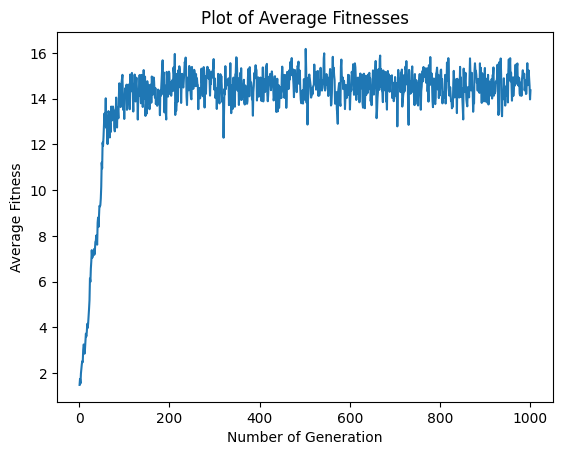

Jooj: 6.9859112508243735
Chocoroll: 2.695837980847389
Tordilla: 0.3156697830673971
Total Weight: 9.99741901473916
Total Value: 18.848363269085596


In [12]:
knapsack = Knapsack(POPULATION_SIZE, CROSSOVER_PROB, MUTATION_PROB, CROSSOVER_RATE, NUM_OF_FOODS, MAX_SNACKS_NUM, MIN_SNACKS_NUM, NUM_OF_ITERS, MAX_WEIGHT, MIN_VALUE)
average_fitnesses, last_population = knapsack.find_solution(True, True)

# Plot of average fitnesses
x_values = list(range(1, len(average_fitnesses) + 1))
plt.plot(x_values, average_fitnesses)
plt.xlabel('Number of Generation')
plt.ylabel('Average Fitness')
plt.title('Plot of Average Fitnesses')
plt.show()
last_genes = last_population[-1][0].get_genes()
total_weight = 0
total_value = 0
for i in range(len(last_genes)):
    if last_genes[i] != 0:
        total_weight += last_genes[i]
        total_value += (last_genes[i] / foods[i].get_weight()) * foods[i].get_value()
        print(f"{foods[i].get_name()}: {last_genes[i]}")
print(f"Total Weight: {total_weight}")
print(f"Total Value: {total_value}")

## *Questions part:*

#### Question 1: What is the problem with a very large or very small initial poplulation?

Both very large and very small population have negative effects on the result. If we have a very small population, the diversity of each generation will be very low and thus, it will violate the concept of mutation and crossover because there is not enough diversity (in terms of chromosomes) in our population in order to make better generations. Also vice versa. Means that if the population is very large, it will take a huge space and plenty of time to find the solution and thus, it will violate the need of handling the algorithm with optimal (or at least good if it is not our most important concern) time and space.


#### Question 2: What is the effect of increasing the population size after generating each generation on the precision and speed of the algorithm?

This approach is oftenly called dynamic population sizing (in terms of increasing it not decreasing!). It has both positive and negative effects on precision (accuracy) and speed of the algorithm and if properly handled, it is a good approach to make the algorithm better in some ways.I will mention effects of it on speed and precision next:

* Speed :

     It can change the process of the algorithm such that leads to a faster convergance to the solution due to the increasement of the population andthus diversity in each generation. On the other hand, changing the size of population dynamically will lead to a much bigger amount of space thatour algorithm needs and also it will take more time because of allocating new memories after each generation.

* Precision :

     It can improve the precision of the algorithm by adapting the population size based on the progress of the optimization and increasing the population size when diversity is low can lead the algorithm to a better solution. However, if the chromosomes with lower fitness are kept in the population in all generations, it can damage to all of our generations and maybe it increases the probability to converge to suboptimal and local maximum solutions.


So it really depends on how we implement this approach in order to take advantage of it.



#### Question 3: Compare the effect of mutation and crossover on the algorithm. Can we only use one of them?

Both mutation and crossover are very important and effective in the genetic algorithm. I will mention the effect of each next:

1. Crossover : Crossover is used to create new generation by creating new chromosomes from chromosomes in the current population. We can use any kind of crossover (one point, two point, n-point, uniform or a desired one) based on our problem.

2. Mutation : Mutation is used to change some genes from a chromosomes often with a low probability.

3. Compare : Crossover is used to create new populations by combining some chromosomes (often two). However, mutation is performed on the genes of one chromosome and it is very useful for exitting the local maximum and getting out of stuck. The probability of crossover is much bigger than mutation (for crossover, it is usually more than 50 percent but for mutation, it is usually less than 1 percent, based on our algorithm and the problem). It is because of that if the mutation probability is high, it can damage our good chromosomes and direct our algorithm to a wrong way.

4. Conclusion: Both mutation and crossover are nessecary for genetic algorithm to find an optimal solution. For determining this, I will show the plot of my algorithm with one of them and without any of them next.

### Without Mutation:

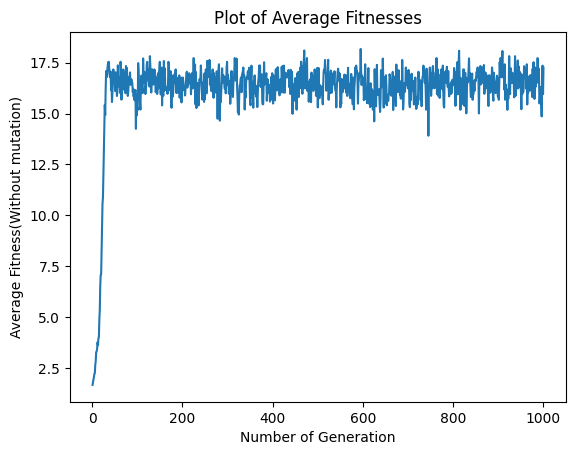

Jooj: 6.853451425665784
Shokolat: 0.2016907084834283
Pastil: 2.7877562518655967
Tordilla: 0.12889764403581028
Total Weight: 9.97179603005062
Total Value: 21.542045634595013


In [13]:
# Without mutation:
mutation_p = 0
knapsack = Knapsack(POPULATION_SIZE, CROSSOVER_PROB, mutation_p, CROSSOVER_RATE, NUM_OF_FOODS, MAX_SNACKS_NUM, MIN_SNACKS_NUM, NUM_OF_ITERS, MAX_WEIGHT, MIN_VALUE)
average_fitnesses, last_population = knapsack.find_solution(True, True)

# Plot of average fitnesses
x_values = list(range(1, len(average_fitnesses) + 1))
plt.plot(x_values, average_fitnesses)
plt.xlabel('Number of Generation')
plt.ylabel('Average Fitness(Without mutation)')
plt.title('Plot of Average Fitnesses')
plt.show()
last_genes = last_population[-1][0].get_genes()
total_weight = 0
total_value = 0
for i in range(len(last_genes)):
    if last_genes[i] != 0:
        total_weight += last_genes[i]
        total_value += (last_genes[i] / foods[i].get_weight()) * foods[i].get_value()
        print(f"{foods[i].get_name()}: {last_genes[i]}")
print(f"Total Weight: {total_weight}")
print(f"Total Value: {total_value}")

As we can see above, the total value (13.17) is much less than the total value with the presence of mutation (21.51) because it got stuck in a local maximum not the optimal one.

### Without Crossover:

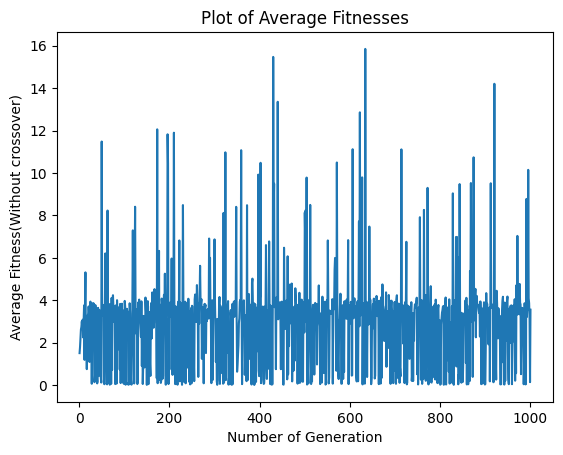

Nani: 1.1045392931660842
Jooj: 4.10354067209088
Saghe-Talaei: 7.230354095142985
Total Weight: 12.438434060399949
Total Value: 18.73494018298003


In [14]:
# Without crossover:
crossover_p = 0
crossover_r = 0
knapsack = Knapsack(POPULATION_SIZE, crossover_p, 0.9, crossover_r, NUM_OF_FOODS, MAX_SNACKS_NUM, MIN_SNACKS_NUM, NUM_OF_ITERS, MAX_WEIGHT, MIN_VALUE)
average_fitnesses, last_population = knapsack.find_solution(False, True)

# Plot of average fitnesses
x_values = list(range(1, len(average_fitnesses) + 1))
plt.plot(x_values, average_fitnesses)
plt.xlabel('Number of Generation')
plt.ylabel('Average Fitness(Without crossover)')
plt.title('Plot of Average Fitnesses')
plt.show()
last_genes = last_population[-1][0].get_genes()
total_weight = 0
total_value = 0
for i in range(len(last_genes)):
    if last_genes[i] != 0:
        total_weight += last_genes[i]
        total_value += (last_genes[i] / foods[i].get_weight()) * foods[i].get_value()
        print(f"{foods[i].get_name()}: {last_genes[i]}")
print(f"Total Weight: {total_weight}")
print(f"Total Value: {total_value}")

As we can see, there is no progress in the algorithm when there is no crossover because the generation won't get better.

### Without Crossover and Mutation:

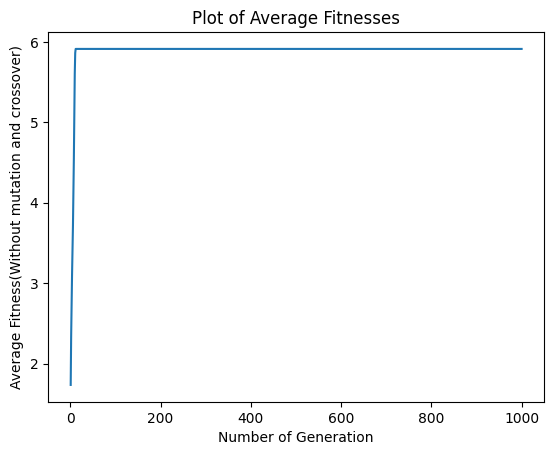

Nani: 1.8068562214931894
Shokolat: 4.050689608679311
Chocoroll: 3.906761783494012
Total Weight: 9.764307613666512
Total Value: 11.741676476277735


In [15]:
# Without both:
crossover_pp = 0
crossover_rr = 0
mutation_pp = 0
knapsack = Knapsack(POPULATION_SIZE, crossover_pp, mutation_pp, crossover_rr, NUM_OF_FOODS, MAX_SNACKS_NUM, MIN_SNACKS_NUM, NUM_OF_ITERS, MAX_WEIGHT, MIN_VALUE)
average_fitnesses, last_population = knapsack.find_solution(False, True)

# Plot of average fitnesses
x_values = list(range(1, len(average_fitnesses) + 1))
plt.plot(x_values, average_fitnesses)
plt.xlabel('Number of Generation')
plt.ylabel('Average Fitness(Without mutation and crossover)')
plt.title('Plot of Average Fitnesses')
plt.show()
last_genes = last_population[-1][0].get_genes()
total_weight = 0
total_value = 0
for i in range(len(last_genes)):
    if last_genes[i] != 0:
        total_weight += last_genes[i]
        total_value += (last_genes[i] / foods[i].get_weight()) * foods[i].get_value()
        print(f"{foods[i].get_name()}: {last_genes[i]}")
print(f"Total Weight: {total_weight}")
print(f"Total Value: {total_value}")

And as I said, without both of them, the algorithm goes completely wrong.

#### Question 4: How can we reach to the solution in a more optimal time in this problem?

The most important factors to reach better solutions in less time are:

* Hyper-parameters
* Defining chromosomes and genes properly
* Fitness function
* Crossover
* Mutation

In this problem, one of the approaches that can accelerate our algorithm is fitnessing by rank. Also not changing the concept of crossover and mutation in this problem is very important too, for example instead of always keeping the third constraint (keeping the number of items in a specific range) correct by changing the crossover, I added a coefficient in my fitness function (W_items) that after some limited iterations, it will hold this constraint correctly (and also for other constraints). This will lead to a great save in time because I didn't change anything in the process of crossover to increase the time of the algorithm. Also, changing the hyper-parameters and trying to find the best of them that correctly fits our problem and algorithm is very important too.

#### Question 5: If the chromosomes stops changing after some time and the algorithm doesn't converge, what should we do?

Actually the thing that is happening in this question is that the algorithm stucks at a local maximum and can't get to the global maximum (or even a better local maximum) from there. One of the reasons of this happening is not using mutation (or using it with a wrong and useless probability). The ways that we can solve this problem are:

1. Using a good mutation with a reasonable probability by changing it's parameter and finding the most suitable one is very effective. Mutation can change the state of a chromosome in a way that it gets to a wrong way in the algorithm in order to exit the local maximum and get to a better solution (also, sometimes it can make the chromosomes better too!).

2. We can set a limit for the number of iterations (generations) of the algorithm in order to if it is not converging, the algorithm stops.

3. Restarting the algorithm by resetting the first population to a diverse random set priodically.

4. At last, changing other hyper-parameters like the population size and crossover probability and rate is always useful.

#### Question 6: How to stop the algorithm if there is not any solution for the problem?

Approaches for this question is very similar to the previous question (question 5). However, one of the most important approaches for this is setting a limitation for number of generations and start the algorithm again with a new population after that. If we use this approach for many times and others in the previous question and still there is no solution, with a high probability we can conclude that there is no answer for the problem.






## *Conclusion*

Genetic algorithms are very good and quick for the problems that deals with big data. However, in order to get to an optimal solution, we need to take much effort to correctly define our parameters that leads to a good solution. Also, it may take much more space than another algorithm if the population size or number of generations is high.


#### Resources:
https://www.youtube.com/watch?v=cxweR4i0ejA

https://www.youtube.com/watch?v=uQj5UNhCPuo

https://www.youtube.com/watch?v=nhT56blfRpE

https://www.mathworks.com/help/gads/what-is-the-genetic-algorithm.html

And lots of other searches!